# Model Output and Parameter Values

Run the model and get and save the output from various layers, the parameter weights, etc

In [1]:
# Required packages
#!pip install torch torchvision pandas numpy matplotlib scipy plotly tensorboard onnx kaleido

In [1]:
# Visualize tensorboard in the notebook
%load_ext tensorboard
# In order to force reload any changes done to the models package files
%load_ext autoreload
%autoreload 2

In [2]:
## Allow import from our custom lib python files
import sys
import os

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(os.path.join(module_path, "lib"))

In [3]:
from models.convmf import ConvMF
from models.base import BaseMF
from datasets.gen_plasma_1d import GenPlasma1DDataset
from framework.saveload import load_checkpoint, load_trained_model
from framework.params import device, use_cuda

import os
from timeit import default_timer
import re
from datetime import datetime
import json

# Supress Pandas future deprecation warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import torch
import onnx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg, sparse 
from torch import nn
from torch.utils.data import DataLoader, random_split, Subset
# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
from torch import profiler

# Viz
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from plotly.subplots import make_subplots
# Settings for plot rendering, makes work with HTML output + jupyer lab + static output
pio.renderers.default = "notebook+plotly_mimetype+png"
# pio.renderers.default = "notebook"

In [5]:
## Params
data_dir = os.path.join("..", "..", "data")
output_dir = os.path.join(data_dir, "output")
tensorboard_dir = os.path.join(output_dir, "tensorboard")

print(f"Using {device} device")

Using cpu device


## Load Data

tensor([[ 9.9534e-09, -6.5338e-09, -3.2841e-08,  ..., -4.4630e-08,
         -2.1763e-08, -6.2504e-10],
        [ 1.5212e-08,  3.9789e-09, -2.0720e-08,  ..., -4.2727e-08,
         -2.5106e-08, -4.7757e-09],
        [ 1.9433e-08,  1.4995e-08, -6.2129e-09,  ..., -3.5748e-08,
         -2.5298e-08, -7.6752e-09],
        ...,
        [-4.7757e-09, -2.5106e-08, -4.2727e-08,  ..., -2.0720e-08,
          3.9788e-09,  1.5212e-08],
        [-6.2504e-10, -2.1763e-08, -4.4630e-08,  ..., -3.2841e-08,
         -6.5339e-09,  9.9534e-09],
        [ 4.4507e-09, -1.5403e-08, -4.1172e-08,  ..., -4.1173e-08,
         -1.5403e-08,  4.4507e-09]]) 12970
16294


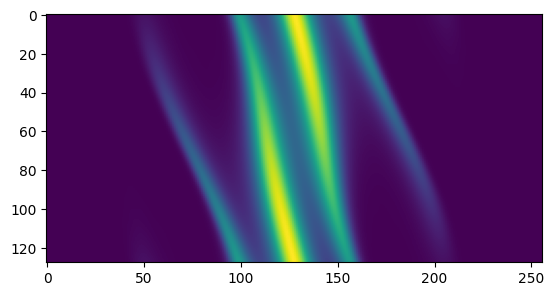

In [8]:
## Params
mat_dirs = [os.path.normpath(data_dir + "/gen_plasma_n128/mat_hdf5/")]

# Load and split the data, and prep for being fed into the NN
# Don't divide data, use all for sequential 
seq_data = GenPlasma1DDataset(mat_dirs, return_imname=True)
seq_dataloader = DataLoader(seq_data, batch_size=1, shuffle=False)

# Divide data into train, validation, test
# Use same code as run_models so that the train_data isn't used
_, validation_data, test_data = random_split(seq_data, [0.7, 0.2, 0.1], generator=torch.Generator().manual_seed(42))
dataloader = DataLoader(validation_data + test_data, batch_size=1, shuffle=True)


print(seq_data[2669][0], validation_data[2][2])
print(len(seq_data))
plt.imshow(seq_data[2669][0])

## Load Models

In [9]:

def load_run_models(runname, output_run_dir):
    with open(os.path.join(output_run_dir, f"details_{runname}.json"), "r") as deets:
        run_details = json.load(deets)
    machine = run_details["run_params"]["machine"]
    run_details.pop("run_params")
    
    models = []
    model_names = []
    model_classes = []
    model_ranks = []
    for c in run_details.keys():
        # The python class of the model is the first part of the model name
        cls = eval(re.search("^([\da-zA-Z]+)_", c).group(1))
        model_str_name = c
    
        
        model = load_trained_model(cls, machine, runname, model_str_name, output_run_dir)
        if model:
            model.eval()
            models.append(model)
            model_names.append(c+"_"+runname)
            model_classes.append(cls)
            model_ranks.append(int(re.search(r"_r(\d+)_", c).group(1)) if re.search(r"_r(\d+)_", c) else 6)
            
    
    # ranks = set(model_ranks)
    # n_ranks = len(ranks)
    # print(models, model_names, model_classes, model_ranks)
    print(model_names, model_classes, model_ranks)
    return models, model_names, model_classes, model_ranks



In [ ]:
models, model_names, model_classes, model_ranks